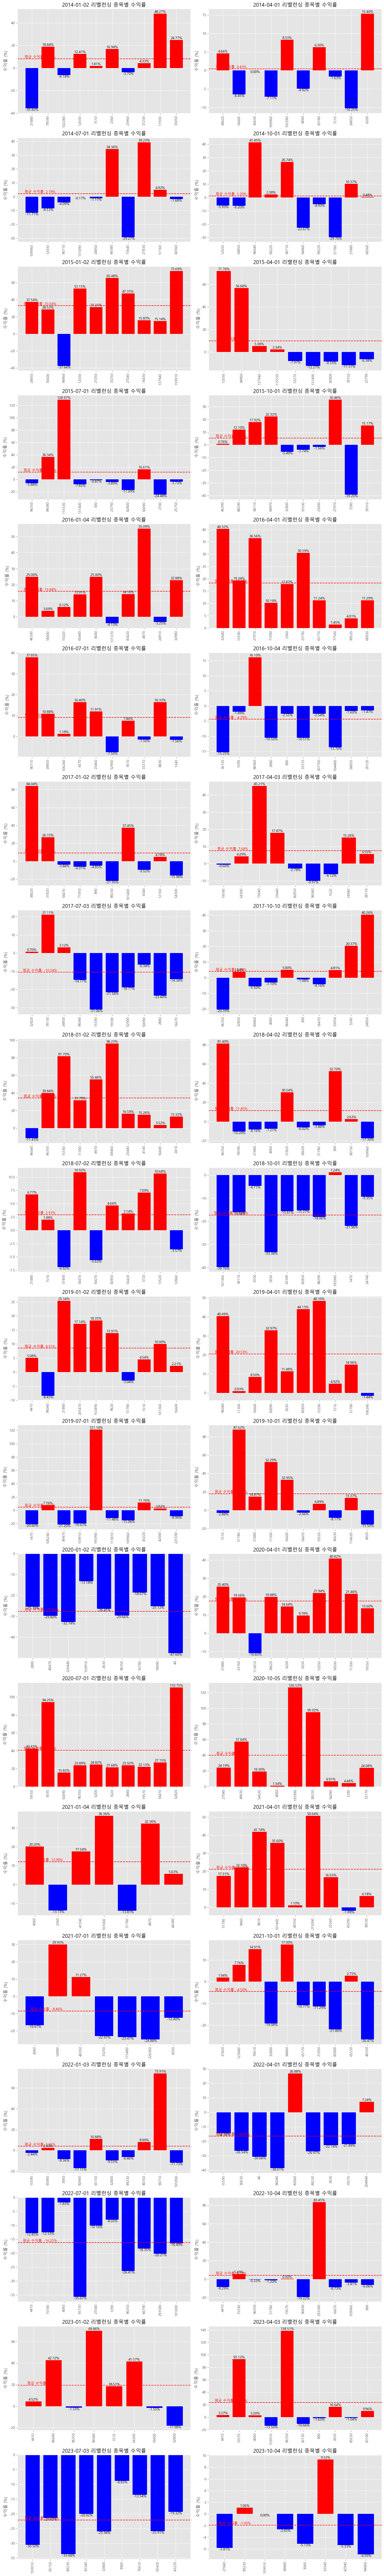

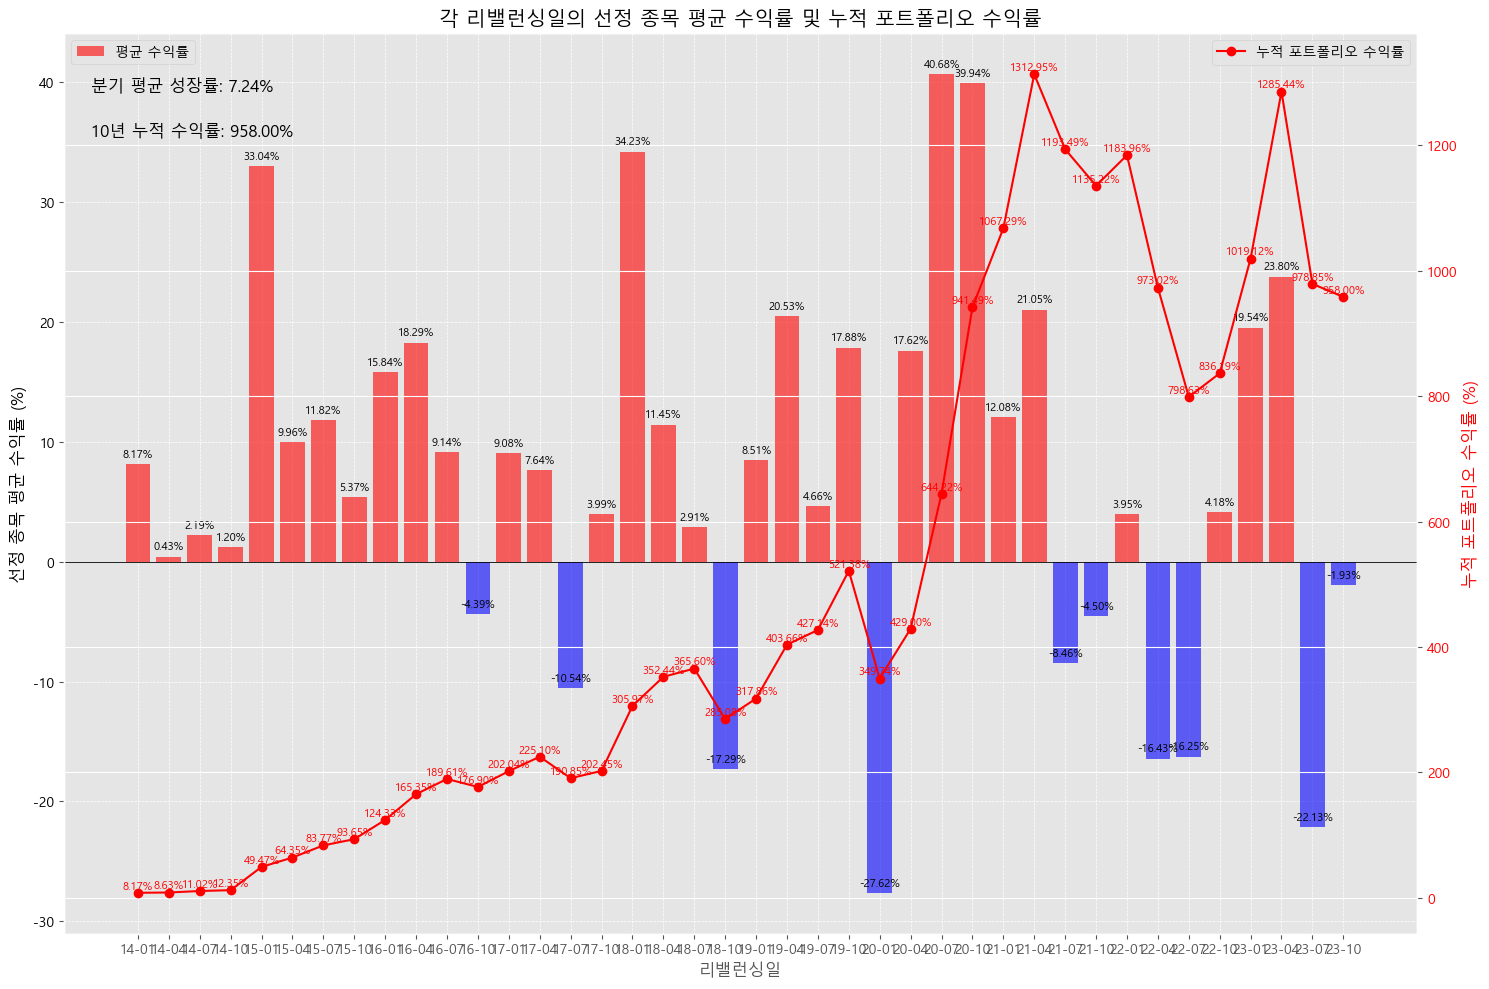

In [1]:
# Deep dive Strategy
# 전체 기간, 머신러닝 적용 X, 누적 수익률 O

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator

# 전략에 따른 종목 선정 및 개별 종목 수익률 계산 함수
def select_stocks(strategy_function, close_df, rebalancing_dates):
    close_df['Date'] = pd.to_datetime(close_df['Date'])  # 날짜를 datetime 객체로 변환
    held_stocks_dict = {}
    stock_returns_dict = {}
    individual_stock_returns_dict = {}
    
    for idx, date in enumerate(rebalancing_dates):
        # 해당 기간의 데이터 추출
        start_date = pd.to_datetime(date) - pd.DateOffset(years=1)
        period_df = close_df[(close_df['Date'] >= start_date) & (close_df['Date'] < pd.to_datetime(date))].drop(columns='Date')
        
        # 전략 함수를 사용하여 종목 선정
        selected_stocks = strategy_function(period_df)
        
        # 선정된 종목 저장
        held_stocks_dict[date] = selected_stocks
        
        # 선정된 종목의 다음 기간 수익률 계산
        if idx + 1 < len(rebalancing_dates):
            next_date = pd.to_datetime(rebalancing_dates[idx + 1])
        else:
            next_date = close_df['Date'].max()
        
        next_period_df = close_df[(close_df['Date'] >= pd.to_datetime(date)) & (close_df['Date'] <= next_date)].drop(columns='Date')
        returns = (next_period_df[selected_stocks].iloc[-1] - next_period_df[selected_stocks].iloc[0]) / next_period_df[selected_stocks].iloc[0]
        
        # 종목별 수익률 저장
        stock_returns_dict[date] = returns.mean() * 100  # 퍼센트 단위로 변환
        individual_stock_returns_dict[date] = returns * 100  # 퍼센트 단위로 변환
    
    return held_stocks_dict, stock_returns_dict, individual_stock_returns_dict


# 기본 전략 함수: 가격이 30% 이상 하락한 종목 중 변동성이 낮은 종목 10개 선정
def default_strategy(period_df):
    # 가격이 30% 이상 하락한 종목 찾기
    price_drop = (period_df.iloc[-1] - period_df.iloc[0]) / period_df.iloc[0]
    dropped_stocks = price_drop[price_drop <= -0.30].index.tolist()
    
    # 해당 종목들의 변동성 계산
    volatility = period_df[dropped_stocks].std()
    
    # 변동성이 낮은 종목 10개 선정
    selected_stocks = volatility.nsmallest(10).index.tolist() if len(volatility) >= 10 else volatility.index.tolist()
    
    return selected_stocks

# 각 리밸런싱일에 대한 개별 주식 수익률을 시각화하는 함수
def visualize_individual_stock_returns(individual_stock_returns_dict):
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] = False
    plt.style.use('ggplot')  # 그래프 스타일 설정
    
    num_plots = len(individual_stock_returns_dict)
    num_columns = 2
    num_rows = num_plots // num_columns + (num_plots % num_columns > 0)

    fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))
    axs = axs.flatten()
    
    for ax, (date, returns) in zip(axs, individual_stock_returns_dict.items()):
        # NaN 값이 있을 경우 제외하고 평균을 계산
        valid_returns = returns.dropna()
        if len(valid_returns) == 0:  # 유효한 수익률이 없는 경우 그래프를 건너뜀
            continue

        stocks = valid_returns.index
        performance = valid_returns.values
        colors = ['red' if r > 0 else 'blue' for r in performance]
        ax.bar(stocks, performance, color=colors)
        ax.set_title(f'{date} 리밸런싱 종목별 수익률')

        ax.xaxis.set_major_locator(FixedLocator(range(len(stocks))))
        ax.set_xticklabels(stocks, rotation=90)
        ax.set_ylabel('수익률 (%)')
        
        # 유효한 수익률만을 사용하여 평균 계산
        average_return = valid_returns.mean()
        ax.axhline(average_return, color='red', linestyle='--')
        if pd.notna(average_return):
            ax.text(0.5, average_return, f'평균 수익률: {average_return:.2f}%', color='red', ha='center', va='bottom')

        # 유효한 위치 값만을 사용하여 텍스트 추가
        for i, v in enumerate(performance):
            if pd.notna(v):
                ax.text(i, v, f"{v:.2f}%", color='black', ha='center', va='bottom' if v > 0 else 'top')

    plt.tight_layout()
    plt.show()

# 포트폴리오 성과를 시각화하는 함수
def visualize_portfolio_performance(portfolio_returns):
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] = False

    # 누적 포트폴리오 수익률 계산
    cumulative_portfolio_returns = [(np.prod([1 + ret/100 for ret in list(portfolio_returns.values())[:i+1]]) - 1) * 100 for i in range(len(portfolio_returns))]

    # 분기 평균 성장률과 누적 수익률 계산
    quarterly_average_growth = np.mean(list(portfolio_returns.values()))
    total_cumulative_return = cumulative_portfolio_returns[-1]

    # 그래프 생성
    fig, ax1 = plt.subplots(figsize=(15, 10))

    # 날짜 형식 변환
    formatted_dates = [date[2:7] for date in portfolio_returns.keys()]

    # 각 리밸런싱일에 선정된 종목들의 평균 수익률 막대그래프로 그리기
    colors = ['red' if value > 0 else 'blue' for value in portfolio_returns.values()]
    bars = ax1.bar(formatted_dates, portfolio_returns.values(), color=colors, label='평균 수익률', alpha=0.6)
    ax1.set_title('각 리밸런싱일의 선정 종목 평균 수익률 및 누적 포트폴리오 수익률')
    ax1.set_xlabel('리밸런싱일')
    ax1.set_ylabel('선정 종목 평균 수익률 (%)', color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax1.axhline(0, color='black', linewidth=0.6)

    # 막대 위에 수치 표시
    for bar, value in zip(bars, portfolio_returns.values()):
        height = bar.get_height()
        ax1.annotate(f'{value:.2f}%',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=8, color='black')

    # 포트폴리오의 누적 수익률 선그래프로 그리기
    ax2 = ax1.twinx()
    lines, = ax2.plot(formatted_dates, cumulative_portfolio_returns, color='red', label='누적 포트폴리오 수익률', marker='o')
    ax2.set_ylabel('누적 포트폴리오 수익률 (%)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # 선 위에 수치 표시
    for i, txt in enumerate(cumulative_portfolio_returns):
        ax2.annotate(f'{txt:.2f}%', 
                     (formatted_dates[i], cumulative_portfolio_returns[i]), 
                     textcoords="offset points", 
                     xytext=(0,3), 
                     ha='center', fontsize=8, color='red')

    # 분기 평균 성장률과 10년 누적 수익률을 그래프에 텍스트로 추가
    ax1.text(0.02, 0.95, f'분기 평균 성장률: {quarterly_average_growth:.2f}%', transform=ax1.transAxes, fontsize=12, color='black', verticalalignment='top')
    ax2.text(0.02, 0.90, f'10년 누적 수익률: {total_cumulative_return:.2f}%', transform=ax1.transAxes, fontsize=12, color='black', verticalalignment='top')

    # 범례 표시
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # 그래프 레이아웃 조정 및 표시
    plt.tight_layout()
    plt.show()


# 메인 함수: 전략을 적용하고 결과를 시각화
def main(strategy_function):
    # 데이터 로드 (실제 경로로 수정 필요)
    close_df = pd.read_csv('reshape_df_1.0.csv')
    close_df['Date'] = pd.to_datetime(close_df['Date'])  # 날짜를 datetime 객체로 변환

    # 리밸런싱일 정의하기
    rebalancing_dates = ['2014-01-02', 
                    '2014-04-01', '2014-07-01', '2014-10-01', '2015-01-02',
                    '2015-04-01', '2015-07-01', '2015-10-01', '2016-01-04',
                    '2016-04-01', '2016-07-01', '2016-10-04', '2017-01-02',
                    '2017-04-03', '2017-07-03', '2017-10-10', '2018-01-02',
                    '2018-04-02', '2018-07-02', '2018-10-01', '2019-01-02',
                    '2019-04-01', '2019-07-01', '2019-10-01', '2020-01-02',
                    '2020-04-01', '2020-07-01', '2020-10-05', '2021-01-04',
                    '2021-04-01', '2021-07-01', '2021-10-01', '2022-01-03',
                    '2022-04-01', '2022-07-01', '2022-10-04', '2023-01-02',
                    '2023-04-03', '2023-07-03', '2023-10-04']

    # 종목 선정 및 수익률 계산
    held_stocks_dict, stock_returns_dict, individual_stock_returns_dict = select_stocks(strategy_function, close_df, rebalancing_dates)

    # 개별 종목 수익률 시각화
    visualize_individual_stock_returns(individual_stock_returns_dict)
    
    # 각 리밸런싱일에 선정된 종목들의 평균 수익률 계산
    portfolio_returns = {date: np.mean(returns) for date, returns in stock_returns_dict.items()}

    # 결과 시각화
    visualize_portfolio_performance(portfolio_returns)

# 기본 전략을 사용하여 메인 함수 실행
if __name__ == "__main__":
    main(default_strategy)

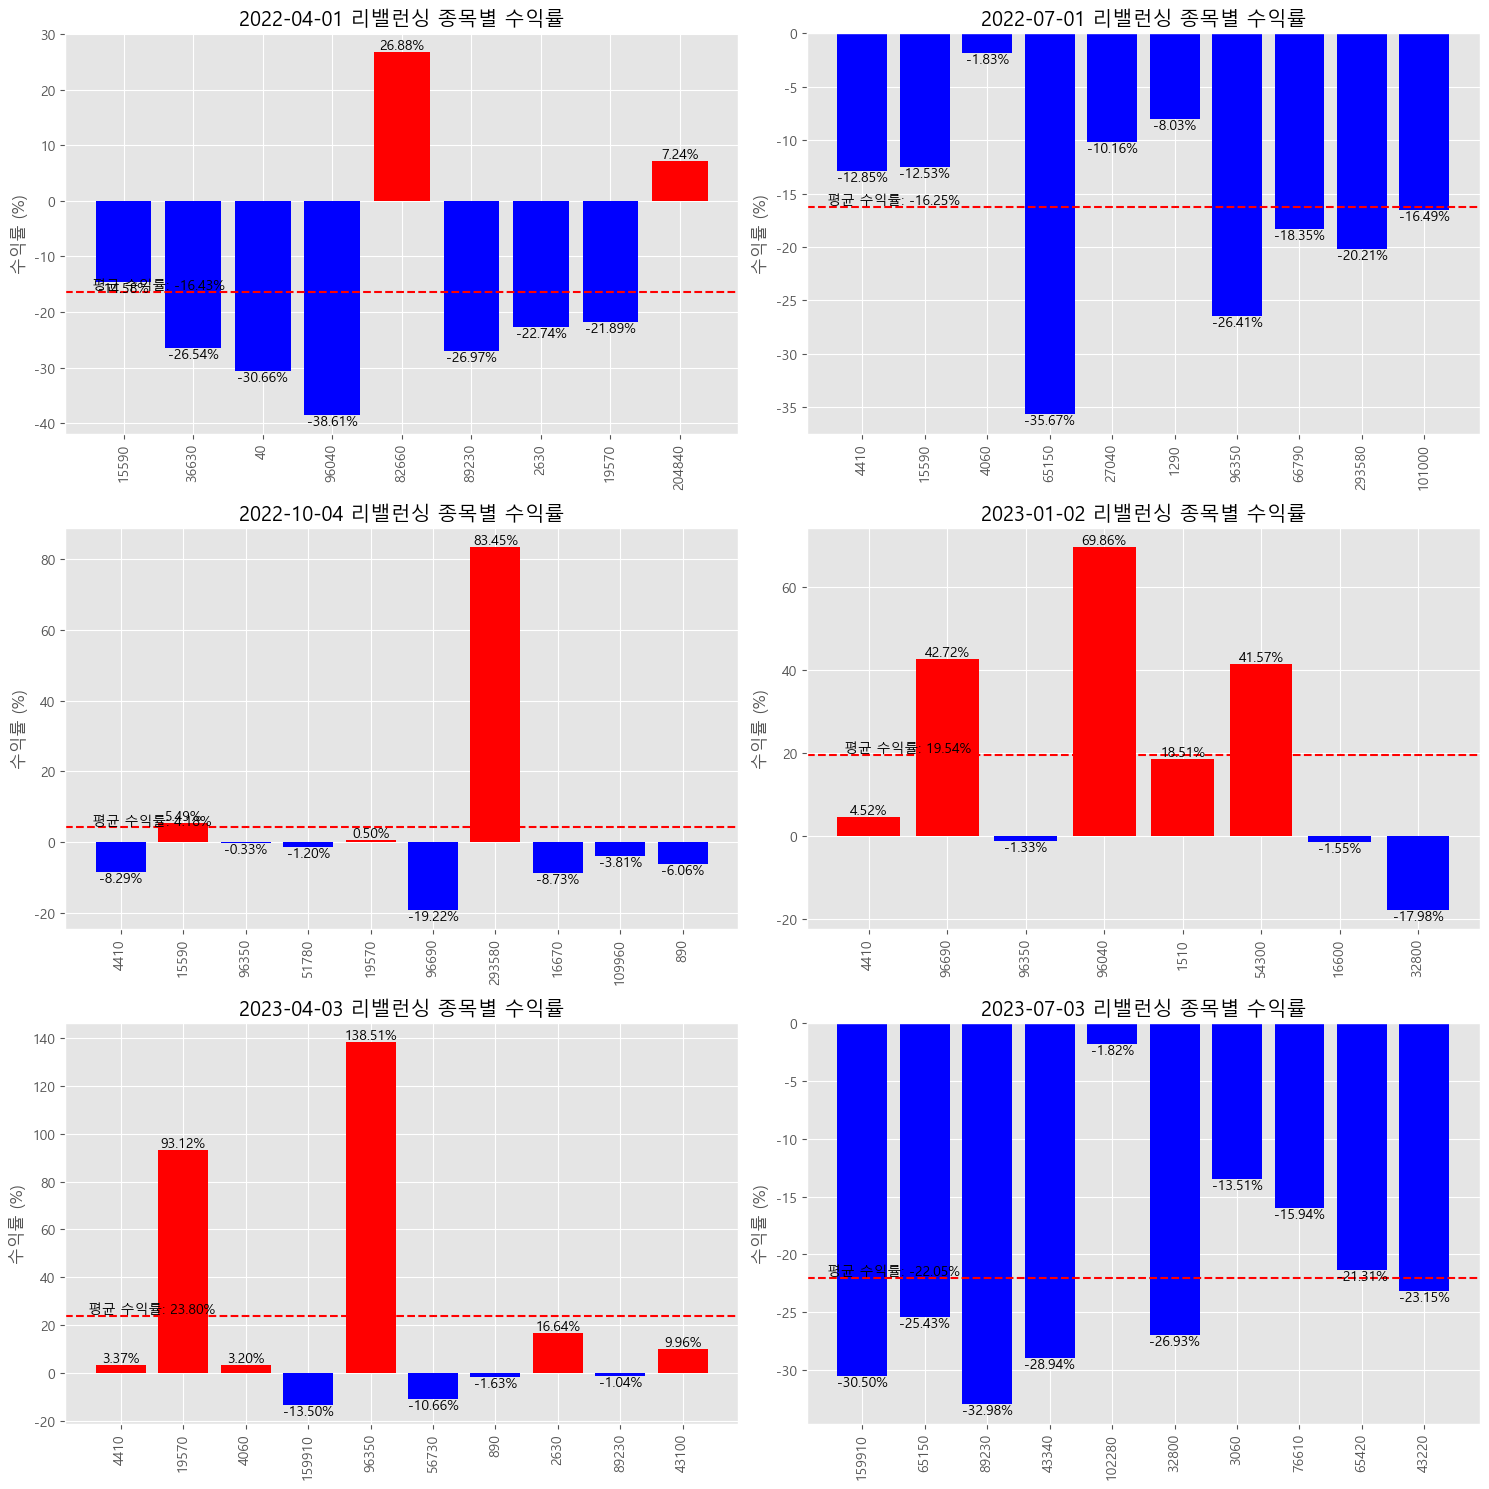

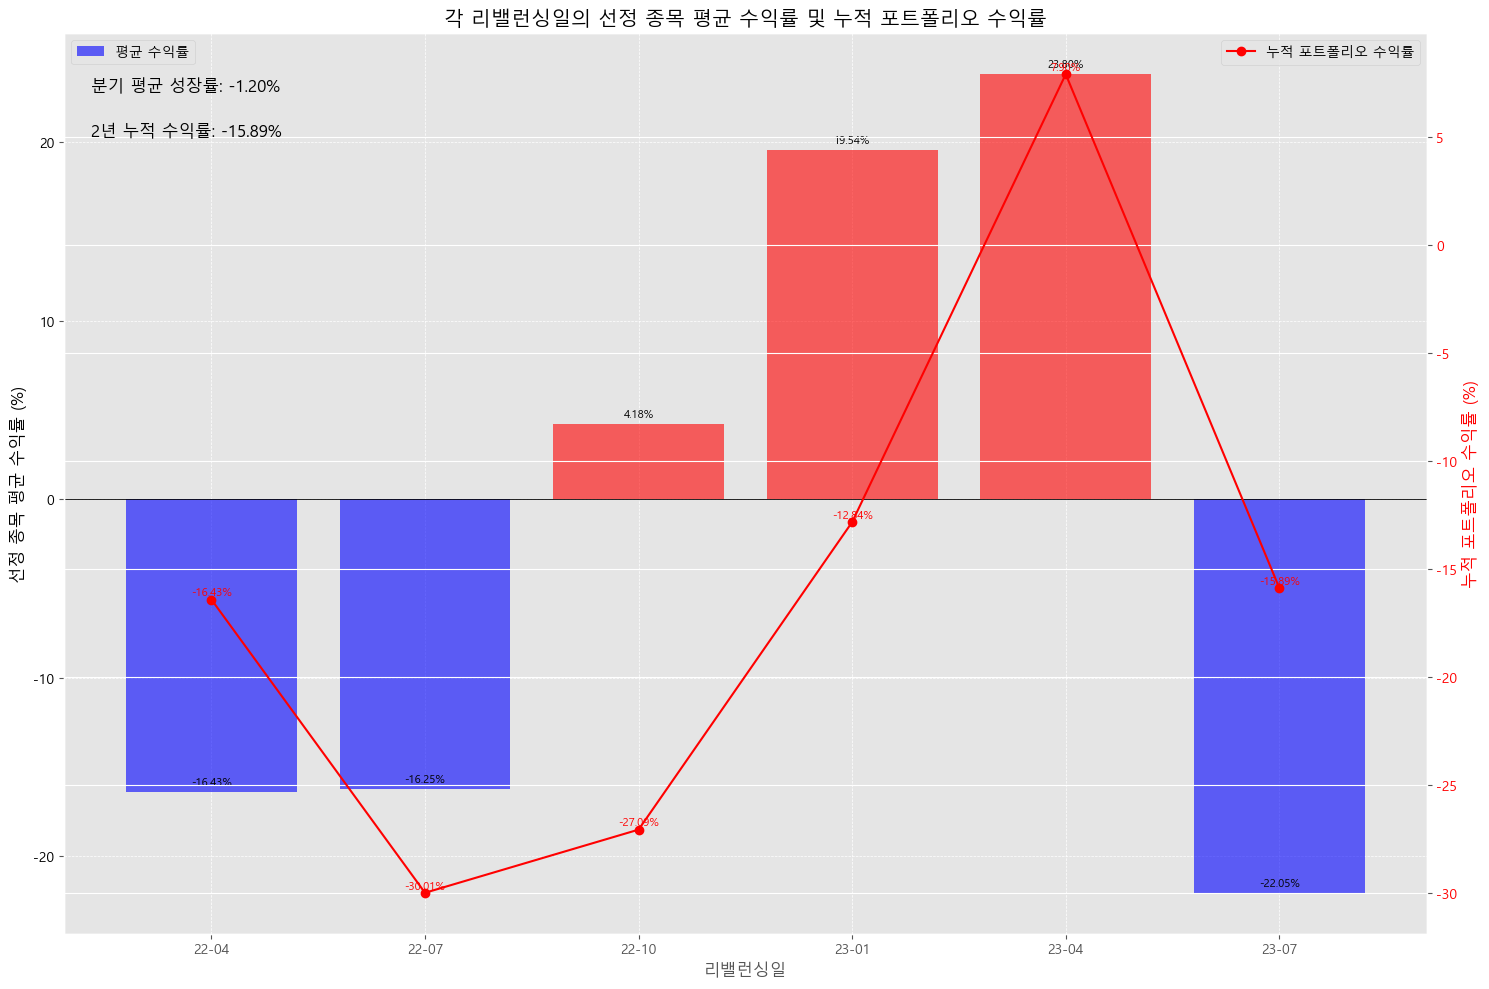

In [9]:
# Deep dive Strategy
# 22년 2분기~23년 3분기(6개 분기), 머신러닝 적용 X

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator

# 전략에 따른 종목 선정 및 개별 종목 수익률 계산 함수
def select_stocks(strategy_function, close_df, rebalancing_dates):
    close_df['Date'] = pd.to_datetime(close_df['Date'])  # 날짜를 datetime 객체로 변환
    held_stocks_dict = {}
    stock_returns_dict = {}
    individual_stock_returns_dict = {}
    
    for idx, date in enumerate(rebalancing_dates):
        # 해당 기간의 데이터 추출
        start_date = pd.to_datetime(date) - pd.DateOffset(years=1)
        period_df = close_df[(close_df['Date'] >= start_date) & (close_df['Date'] < pd.to_datetime(date))].drop(columns='Date')
        
        # 전략 함수를 사용하여 종목 선정
        selected_stocks = strategy_function(period_df)
        
        # 선정된 종목 저장
        held_stocks_dict[date] = selected_stocks
        
        # 선정된 종목의 다음 기간 수익률 계산
        if idx + 1 < len(rebalancing_dates):
            next_date = pd.to_datetime(rebalancing_dates[idx + 1])
        else:
            next_date = close_df['Date'].max()
        
        next_period_df = close_df[(close_df['Date'] >= pd.to_datetime(date)) & (close_df['Date'] <= next_date)].drop(columns='Date')
        returns = (next_period_df[selected_stocks].iloc[-1] - next_period_df[selected_stocks].iloc[0]) / next_period_df[selected_stocks].iloc[0]
        
        # 종목별 수익률 저장
        stock_returns_dict[date] = returns.mean() * 100  # 퍼센트 단위로 변환
        individual_stock_returns_dict[date] = returns * 100  # 퍼센트 단위로 변환
    
    return held_stocks_dict, stock_returns_dict, individual_stock_returns_dict


# 기본 전략 함수: 가격이 30% 이상 하락한 종목 중 변동성이 낮은 종목 10개 선정
def default_strategy(period_df):
    # 가격이 30% 이상 하락한 종목 찾기
    price_drop = (period_df.iloc[-1] - period_df.iloc[0]) / period_df.iloc[0]
    dropped_stocks = price_drop[price_drop <= -0.30].index.tolist()
    
    # 해당 종목들의 변동성 계산
    volatility = period_df[dropped_stocks].std()
    
    # 변동성이 낮은 종목 10개 선정
    selected_stocks = volatility.nsmallest(10).index.tolist() if len(volatility) >= 10 else volatility.index.tolist()
    
    return selected_stocks

# 각 리밸런싱일에 대한 개별 주식 수익률을 시각화하는 함수
def visualize_individual_stock_returns(individual_stock_returns_dict):
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] = False
    plt.style.use('ggplot')  # 그래프 스타일 설정
    
    num_plots = len(individual_stock_returns_dict)
    num_columns = 2
    num_rows = num_plots // num_columns + (num_plots % num_columns > 0)

    fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))
    axs = axs.flatten()
    
    for ax, (date, returns) in zip(axs, individual_stock_returns_dict.items()):
        # NaN 값이 있을 경우 제외하고 평균을 계산
        valid_returns = returns.dropna()
        if len(valid_returns) == 0:  # 유효한 수익률이 없는 경우 그래프를 건너뜀
            continue

        stocks = valid_returns.index
        performance = valid_returns.values
        colors = ['red' if r > 0 else 'blue' for r in performance]
        ax.bar(stocks, performance, color=colors)
        ax.set_title(f'{date} 리밸런싱 종목별 수익률')

        ax.xaxis.set_major_locator(FixedLocator(range(len(stocks))))
        ax.set_xticklabels(stocks, rotation=90)
        ax.set_ylabel('수익률 (%)')
        
        # 유효한 수익률만을 사용하여 평균 계산
        average_return = valid_returns.mean()
        ax.axhline(average_return, color='red', linestyle='--')
        if pd.notna(average_return):
            ax.text(0.5, average_return, f'평균 수익률: {average_return:.2f}%', color='black', ha='center', va='bottom')

        # 유효한 위치 값만을 사용하여 텍스트 추가
        for i, v in enumerate(performance):
            if pd.notna(v):
                ax.text(i, v, f"{v:.2f}%", color='black', ha='center', va='bottom' if v > 0 else 'top')

    plt.tight_layout()
    plt.show()

# 포트폴리오 성과를 시각화하는 함수
def visualize_portfolio_performance(portfolio_returns):
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] = False

    # 누적 포트폴리오 수익률 계산
    cumulative_portfolio_returns = [(np.prod([1 + ret/100 for ret in list(portfolio_returns.values())[:i+1]]) - 1) * 100 for i in range(len(portfolio_returns))]

    # 분기 평균 성장률과 누적 수익률 계산
    quarterly_average_growth = np.mean(list(portfolio_returns.values()))
    total_cumulative_return = cumulative_portfolio_returns[-1]

    # 그래프 생성
    fig, ax1 = plt.subplots(figsize=(15, 10))

    # 날짜 형식 변환
    formatted_dates = [date[2:7] for date in portfolio_returns.keys()]

    # 각 리밸런싱일에 선정된 종목들의 평균 수익률 막대그래프로 그리기
    colors = ['red' if value > 0 else 'blue' for value in portfolio_returns.values()]
    bars = ax1.bar(formatted_dates, portfolio_returns.values(), color=colors, label='평균 수익률', alpha=0.6)
    ax1.set_title('각 리밸런싱일의 선정 종목 평균 수익률 및 누적 포트폴리오 수익률')
    ax1.set_xlabel('리밸런싱일')
    ax1.set_ylabel('선정 종목 평균 수익률 (%)', color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax1.axhline(0, color='black', linewidth=0.6)

    # 막대 위에 수치 표시
    for bar, value in zip(bars, portfolio_returns.values()):
        height = bar.get_height()
        ax1.annotate(f'{value:.2f}%',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=8, color='black')

    # 포트폴리오의 누적 수익률 선그래프로 그리기
    ax2 = ax1.twinx()
    lines, = ax2.plot(formatted_dates, cumulative_portfolio_returns, color='red', label='누적 포트폴리오 수익률', marker='o')
    ax2.set_ylabel('누적 포트폴리오 수익률 (%)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # 선 위에 수치 표시
    for i, txt in enumerate(cumulative_portfolio_returns):
        ax2.annotate(f'{txt:.2f}%', 
                     (formatted_dates[i], cumulative_portfolio_returns[i]), 
                     textcoords="offset points", 
                     xytext=(0,3), 
                     ha='center', fontsize=8, color='red')

    # 분기 평균 성장률과 10년 누적 수익률을 그래프에 텍스트로 추가
    ax1.text(0.02, 0.95, f'분기 평균 성장률: {quarterly_average_growth:.2f}%', transform=ax1.transAxes, fontsize=12, color='black', verticalalignment='top')
    ax2.text(0.02, 0.90, f'2년 누적 수익률: {total_cumulative_return:.2f}%', transform=ax1.transAxes, fontsize=12, color='black', verticalalignment='top')

    # 범례 표시
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # 그래프 레이아웃 조정 및 표시
    plt.tight_layout()
    plt.show()


# 메인 함수: 전략을 적용하고 결과를 시각화
def main(strategy_function):
    # 데이터 로드 (실제 경로로 수정 필요)
    close_df = pd.read_csv('reshape_df_1.0.csv')
    close_df['Date'] = pd.to_datetime(close_df['Date'])  # 날짜를 datetime 객체로 변환

    # 리밸런싱일 정의하기
    rebalancing_dates = [
                    '2022-04-01', '2022-07-01', '2022-10-04', '2023-01-02',
                    '2023-04-03', '2023-07-03']

    # 종목 선정 및 수익률 계산
    held_stocks_dict, stock_returns_dict, individual_stock_returns_dict = select_stocks(strategy_function, close_df, rebalancing_dates)

    # 개별 종목 수익률 시각화
    visualize_individual_stock_returns(individual_stock_returns_dict)
    
    # 각 리밸런싱일에 선정된 종목들의 평균 수익률 계산
    portfolio_returns = {date: np.mean(returns) for date, returns in stock_returns_dict.items()}

    # 결과 시각화
    visualize_portfolio_performance(portfolio_returns)

# 기본 전략을 사용하여 메인 함수 실행
if __name__ == "__main__":
    main(default_strategy)

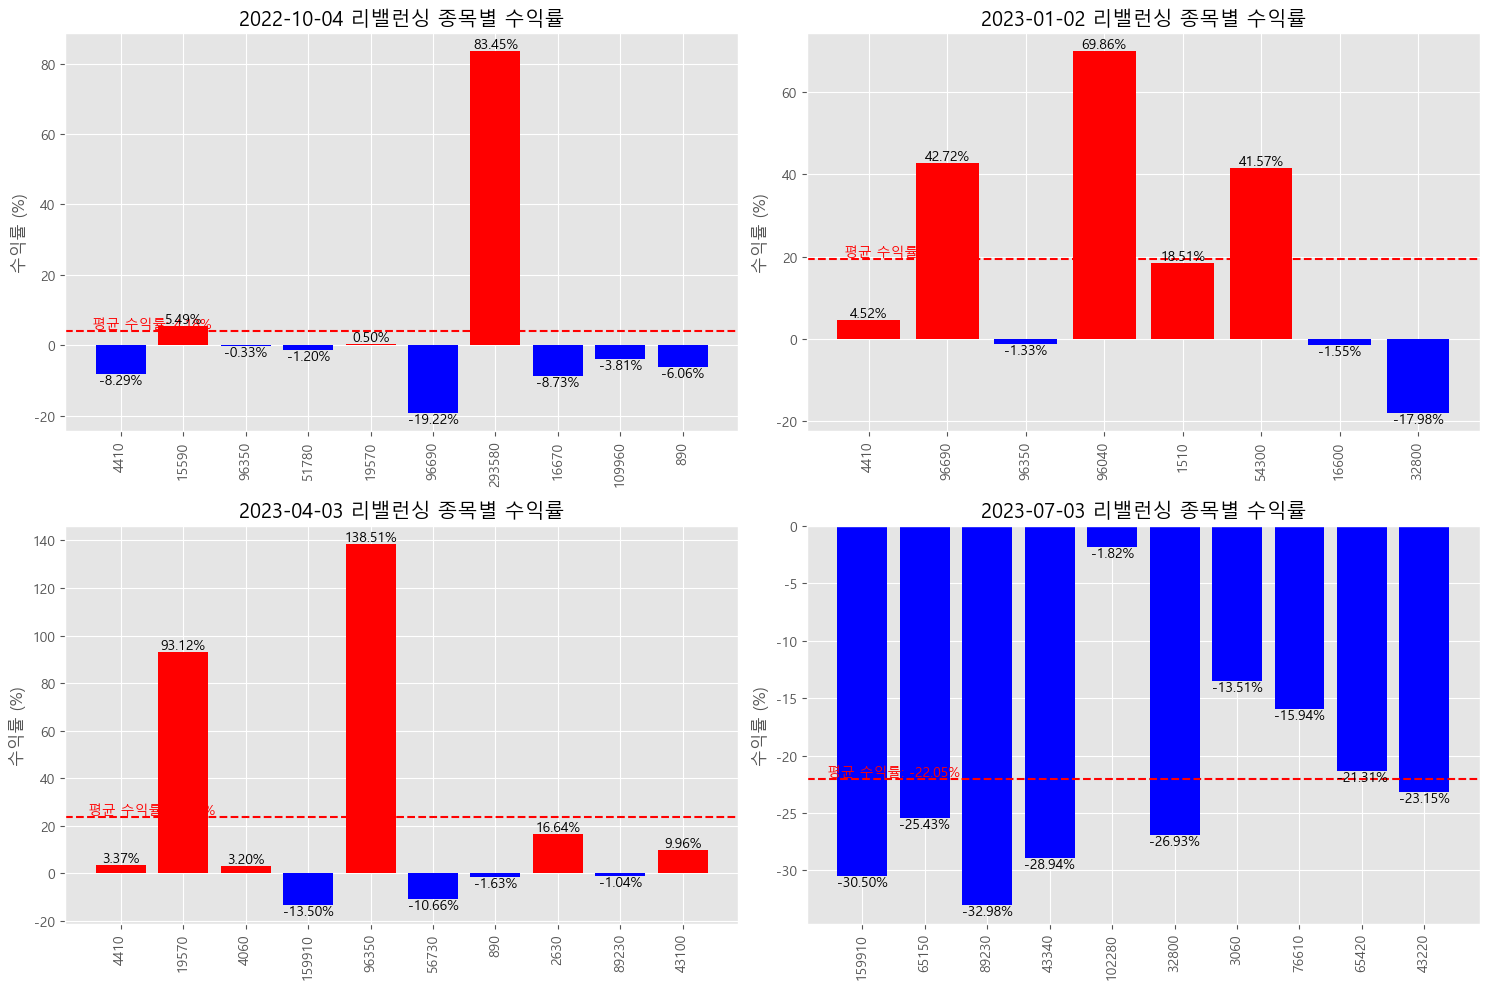

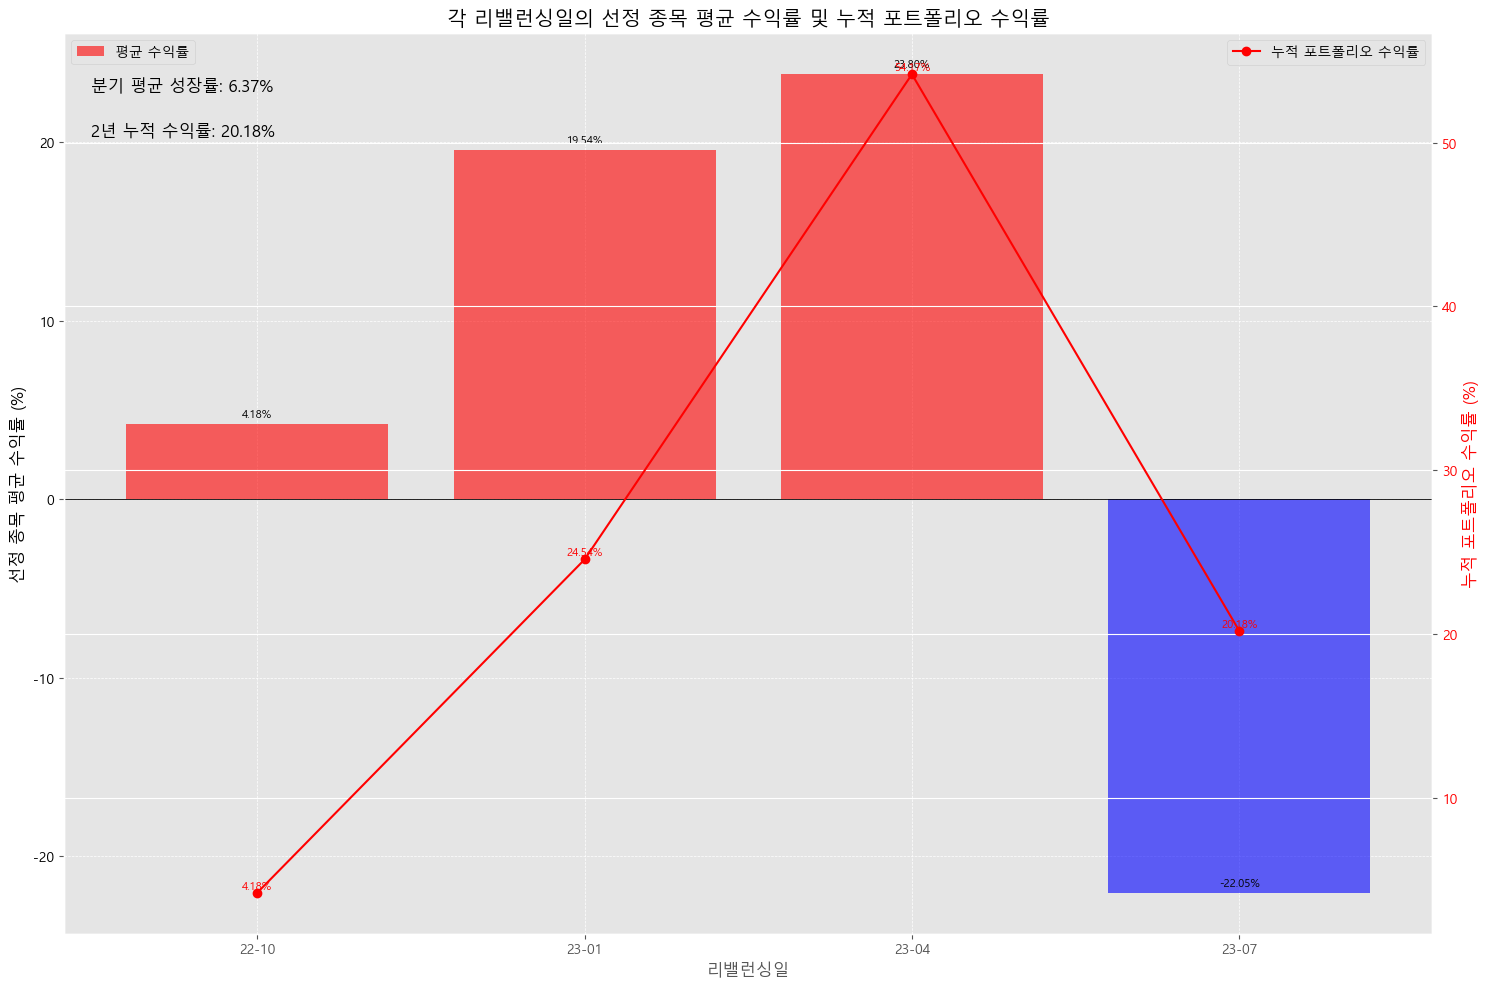

In [8]:
# Deep dive Strategy
# 22년 2분기~23년 3분기(6개 분기), 머신러닝 적용 X

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator

# 전략에 따른 종목 선정 및 개별 종목 수익률 계산 함수
def select_stocks(strategy_function, close_df, rebalancing_dates):
    close_df['Date'] = pd.to_datetime(close_df['Date'])  # 날짜를 datetime 객체로 변환
    held_stocks_dict = {}
    stock_returns_dict = {}
    individual_stock_returns_dict = {}
    
    for idx, date in enumerate(rebalancing_dates):
        # 해당 기간의 데이터 추출
        start_date = pd.to_datetime(date) - pd.DateOffset(years=1)
        period_df = close_df[(close_df['Date'] >= start_date) & (close_df['Date'] < pd.to_datetime(date))].drop(columns='Date')
        
        # 전략 함수를 사용하여 종목 선정
        selected_stocks = strategy_function(period_df)
        
        # 선정된 종목 저장
        held_stocks_dict[date] = selected_stocks
        
        # 선정된 종목의 다음 기간 수익률 계산
        if idx + 1 < len(rebalancing_dates):
            next_date = pd.to_datetime(rebalancing_dates[idx + 1])
        else:
            next_date = close_df['Date'].max()
        
        next_period_df = close_df[(close_df['Date'] >= pd.to_datetime(date)) & (close_df['Date'] <= next_date)].drop(columns='Date')
        returns = (next_period_df[selected_stocks].iloc[-1] - next_period_df[selected_stocks].iloc[0]) / next_period_df[selected_stocks].iloc[0]
        
        # 종목별 수익률 저장
        stock_returns_dict[date] = returns.mean() * 100  # 퍼센트 단위로 변환
        individual_stock_returns_dict[date] = returns * 100  # 퍼센트 단위로 변환
    
    return held_stocks_dict, stock_returns_dict, individual_stock_returns_dict

# 기본 전략 함수: 가격이 30% 이상 하락한 종목 중 변동성이 낮은 종목 10개 선정
def default_strategy(period_df):
    # 가격이 30% 이상 하락한 종목 찾기
    price_drop = (period_df.iloc[-1] - period_df.iloc[0]) / period_df.iloc[0]
    dropped_stocks = price_drop[price_drop <= -0.30].index.tolist()
    
    # 해당 종목들의 변동성 계산
    volatility = period_df[dropped_stocks].std()
    
    # 변동성이 낮은 종목 10개 선정
    selected_stocks = volatility.nsmallest(10).index.tolist() if len(volatility) >= 10 else volatility.index.tolist()
    
    return selected_stocks

# 각 리밸런싱일에 대한 개별 주식 수익률을 시각화하는 함수
def visualize_individual_stock_returns(individual_stock_returns_dict):
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] = False
    plt.style.use('ggplot')  # 그래프 스타일 설정
    
    num_plots = len(individual_stock_returns_dict)
    num_columns = 2
    num_rows = num_plots // num_columns + (num_plots % num_columns > 0)

    fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))
    axs = axs.flatten()
    
    for ax, (date, returns) in zip(axs, individual_stock_returns_dict.items()):
        # NaN 값이 있을 경우 제외하고 평균을 계산
        valid_returns = returns.dropna()
        if len(valid_returns) == 0:  # 유효한 수익률이 없는 경우 그래프를 건너뜀
            continue

        stocks = valid_returns.index
        performance = valid_returns.values
        colors = ['red' if r > 0 else 'blue' for r in performance]
        ax.bar(stocks, performance, color=colors)
        ax.set_title(f'{date} 리밸런싱 종목별 수익률')

        ax.xaxis.set_major_locator(FixedLocator(range(len(stocks))))
        ax.set_xticklabels(stocks, rotation=90)
        ax.set_ylabel('수익률 (%)')
        
        # 유효한 수익률만을 사용하여 평균 계산
        average_return = valid_returns.mean()
        ax.axhline(average_return, color='red', linestyle='--')
        if pd.notna(average_return):
            ax.text(0.5, average_return, f'평균 수익률: {average_return:.2f}%', color='red', ha='center', va='bottom')

        # 유효한 위치 값만을 사용하여 텍스트 추가
        for i, v in enumerate(performance):
            if pd.notna(v):
                ax.text(i, v, f"{v:.2f}%", color='black', ha='center', va='bottom' if v > 0 else 'top')

    plt.tight_layout()
    plt.show()

# 포트폴리오 성과를 시각화하는 함수
def visualize_portfolio_performance(portfolio_returns):
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] = False

    # 누적 포트폴리오 수익률 계산
    cumulative_portfolio_returns = [(np.prod([1 + ret/100 for ret in list(portfolio_returns.values())[:i+1]]) - 1) * 100 for i in range(len(portfolio_returns))]

    # 분기 평균 성장률과 누적 수익률 계산
    quarterly_average_growth = np.mean(list(portfolio_returns.values()))
    total_cumulative_return = cumulative_portfolio_returns[-1]

    # 그래프 생성
    fig, ax1 = plt.subplots(figsize=(15, 10))

    # 날짜 형식 변환
    formatted_dates = [date[2:7] for date in portfolio_returns.keys()]

    # 각 리밸런싱일에 선정된 종목들의 평균 수익률 막대그래프로 그리기
    colors = ['red' if value > 0 else 'blue' for value in portfolio_returns.values()]
    bars = ax1.bar(formatted_dates, portfolio_returns.values(), color=colors, label='평균 수익률', alpha=0.6)
    ax1.set_title('각 리밸런싱일의 선정 종목 평균 수익률 및 누적 포트폴리오 수익률')
    ax1.set_xlabel('리밸런싱일')
    ax1.set_ylabel('선정 종목 평균 수익률 (%)', color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax1.axhline(0, color='black', linewidth=0.6)

    # 막대 위에 수치 표시
    for bar, value in zip(bars, portfolio_returns.values()):
        height = bar.get_height()
        ax1.annotate(f'{value:.2f}%',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=8, color='black')

    # 포트폴리오의 누적 수익률 선그래프로 그리기
    ax2 = ax1.twinx()
    lines, = ax2.plot(formatted_dates, cumulative_portfolio_returns, color='red', label='누적 포트폴리오 수익률', marker='o')
    ax2.set_ylabel('누적 포트폴리오 수익률 (%)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # 선 위에 수치 표시
    for i, txt in enumerate(cumulative_portfolio_returns):
        ax2.annotate(f'{txt:.2f}%', 
                     (formatted_dates[i], cumulative_portfolio_returns[i]), 
                     textcoords="offset points", 
                     xytext=(0,3), 
                     ha='center', fontsize=8, color='red')

    # 분기 평균 성장률과 10년 누적 수익률을 그래프에 텍스트로 추가
    ax1.text(0.02, 0.95, f'분기 평균 성장률: {quarterly_average_growth:.2f}%', transform=ax1.transAxes, fontsize=12, color='black', verticalalignment='top')
    ax2.text(0.02, 0.90, f'2년 누적 수익률: {total_cumulative_return:.2f}%', transform=ax1.transAxes, fontsize=12, color='black', verticalalignment='top')

    # 범례 표시
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # 그래프 레이아웃 조정 및 표시
    plt.tight_layout()
    plt.show()


# 메인 함수: 전략을 적용하고 결과를 시각화
def main(strategy_function):
    # 데이터 로드 (실제 경로로 수정 필요)
    close_df = pd.read_csv('reshape_df_1.0.csv')
    close_df['Date'] = pd.to_datetime(close_df['Date'])  # 날짜를 datetime 객체로 변환

    # 리밸런싱일 정의하기
    rebalancing_dates = [
                    '2022-10-04', '2023-01-02',
                    '2023-04-03', '2023-07-03']

    # 종목 선정 및 수익률 계산
    held_stocks_dict, stock_returns_dict, individual_stock_returns_dict = select_stocks(strategy_function, close_df, rebalancing_dates)

    # 개별 종목 수익률 시각화
    visualize_individual_stock_returns(individual_stock_returns_dict)
    
    # 각 리밸런싱일에 선정된 종목들의 평균 수익률 계산
    portfolio_returns = {date: np.mean(returns) for date, returns in stock_returns_dict.items()}

    # 결과 시각화
    visualize_portfolio_performance(portfolio_returns)

# 기본 전략을 사용하여 메인 함수 실행
if __name__ == "__main__":
    main(default_strategy)

In [3]:
# Deep Dive 리밸런싱일 당일 보유종목 추출

# 전략에 따른 종목 선정 및 개별 종목 수익률 계산 함수
def select_stocks(strategy_function, close_df, rebalancing_dates):
    close_df['Date'] = pd.to_datetime(close_df['Date'])  # 날짜를 datetime 객체로 변환
    held_stocks_dict = {}
    stock_returns_dict = {}
    individual_stock_returns_dict = {}
    
    for idx, date in enumerate(rebalancing_dates):
        # 해당 기간의 데이터 추출
        start_date = pd.to_datetime(date) - pd.DateOffset(years=1)
        period_df = close_df[(close_df['Date'] >= start_date) & (close_df['Date'] < pd.to_datetime(date))].drop(columns='Date')
        
        # 전략 함수를 사용하여 종목 선정
        selected_stocks = strategy_function(period_df)
        
        # 선정된 종목 저장
        held_stocks_dict[date] = selected_stocks
        
        # 선정된 종목의 다음 기간 수익률 계산
        if idx + 1 < len(rebalancing_dates):
            next_date = pd.to_datetime(rebalancing_dates[idx + 1])
        else:
            next_date = close_df['Date'].max()
        
        next_period_df = close_df[(close_df['Date'] >= pd.to_datetime(date)) & (close_df['Date'] <= next_date)].drop(columns='Date')
        returns = (next_period_df[selected_stocks].iloc[-1] - next_period_df[selected_stocks].iloc[0]) / next_period_df[selected_stocks].iloc[0]
        
        # 종목별 수익률 저장
        stock_returns_dict[date] = returns.mean() * 100  # 퍼센트 단위로 변환
        individual_stock_returns_dict[date] = returns * 100  # 퍼센트 단위로 변환
    
    return held_stocks_dict, stock_returns_dict, individual_stock_returns_dict

# 기본 전략 함수: 가격이 30% 이상 하락한 종목 중 변동성이 낮은 종목 10개 선정
def default_strategy(period_df):
    # 가격이 30% 이상 하락한 종목 찾기
    price_drop = (period_df.iloc[-1] - period_df.iloc[0]) / period_df.iloc[0]
    dropped_stocks = price_drop[price_drop <= -0.30].index.tolist()
    
    # 해당 종목들의 변동성 계산
    volatility = period_df[dropped_stocks].std()
    
    # 변동성이 낮은 종목 10개 선정
    selected_stocks = volatility.nsmallest(10).index.tolist() if len(volatility) >= 10 else volatility.index.tolist()
    
    return selected_stocks

# CSV 파일을 읽어 DataFrame 생성
close_df = pd.read_csv('reshape_df_1.0.csv')
close_df['Date'] = pd.to_datetime(close_df['Date'])  # 'Date' 열을 datetime 객체로 변환

# 리밸런싱 날짜를 datetime 객체로 변환
rebalancing_dates = pd.to_datetime(['2014-01-02', 
                    '2014-04-01', '2014-07-01', '2014-10-01', '2015-01-02',
                    '2015-04-01', '2015-07-01', '2015-10-01', '2016-01-04',
                    '2016-04-01', '2016-07-01', '2016-10-04', '2017-01-02',
                    '2017-04-03', '2017-07-03', '2017-10-10', '2018-01-02',
                    '2018-04-02', '2018-07-02', '2018-10-01', '2019-01-02',
                    '2019-04-01', '2019-07-01', '2019-10-01', '2020-01-02',
                    '2020-04-01', '2020-07-01', '2020-10-05', '2021-01-04',
                    '2021-04-01', '2021-07-01', '2021-10-01', '2022-01-03',
                    '2022-04-01', '2022-07-01', '2022-10-04', '2023-01-02',
                    '2023-04-03', '2023-07-03', '2023-10-04'])

# select_stocks 함수 실행
held_stocks_dict, stock_returns_dict, individual_stock_returns_dict = select_stocks(default_strategy, close_df, rebalancing_dates)

# 종목 코드를 6자리로 맞추기 위해 앞에 0을 추가하는 함수
def format_stock_codes(stock_list):
    return [str(stock).zfill(6) for stock in stock_list]

# 종목 코드 포맷 변경 (held_stocks_dict)
formatted_held_stocks_dict = {date: format_stock_codes(stock_list) for date, stock_list in held_stocks_dict.items()}

# 종목 코드 포맷 변경 (individual_stock_returns_dict)
formatted_individual_stock_returns_dict = {}
for date, returns in individual_stock_returns_dict.items():
    formatted_returns = returns.rename(index=lambda x: str(x).zfill(6))
    formatted_individual_stock_returns_dict[date] = formatted_returns

# 결과 출력
print("선정된 종목들 (0으로 포맷된 코드):")
print(formatted_held_stocks_dict)

print("\n평균 수익률:")
print(stock_returns_dict)

print("\n개별 종목 수익률 (0으로 포맷된 코드):")
print(formatted_individual_stock_returns_dict)


선정된 종목들 (0으로 포맷된 코드):
{Timestamp('2014-01-02 00:00:00'): ['021880', '078590', '102280', '012030', '001510', '002360', '023960', '037230', '011930', '033050'], Timestamp('2014-04-01 00:00:00'): ['038620', '016600', '036630', '109960', '102280', '004060', '020180', '001510', '024850', '006200'], Timestamp('2014-07-01 00:00:00'): ['109960', '012030', '090710', '131090', '024850', '044380', '073640', '027830', '051160', '060560'], Timestamp('2014-10-01 00:00:00'): ['012030', '024850', '096040', '058220', '090710', '094860', '099220', '051780', '021880', '060560'], Timestamp('2015-01-02 00:00:00'): ['024850', '016600', '094860', '012030', '021050', '033250', '027040', '074430', '137940', '159910'], Timestamp('2015-04-01 00:00:00'): ['012030', '094860', '137940', '115530', '053270', '131400', '082800', '011330', '078150', '023790'], Timestamp('2015-07-01 00:00:00'): ['096350', '096040', '115530', '131400', '000300', '023790', '082800', '050090', '002700', '025750'], Timestamp('2015-10-01 00:

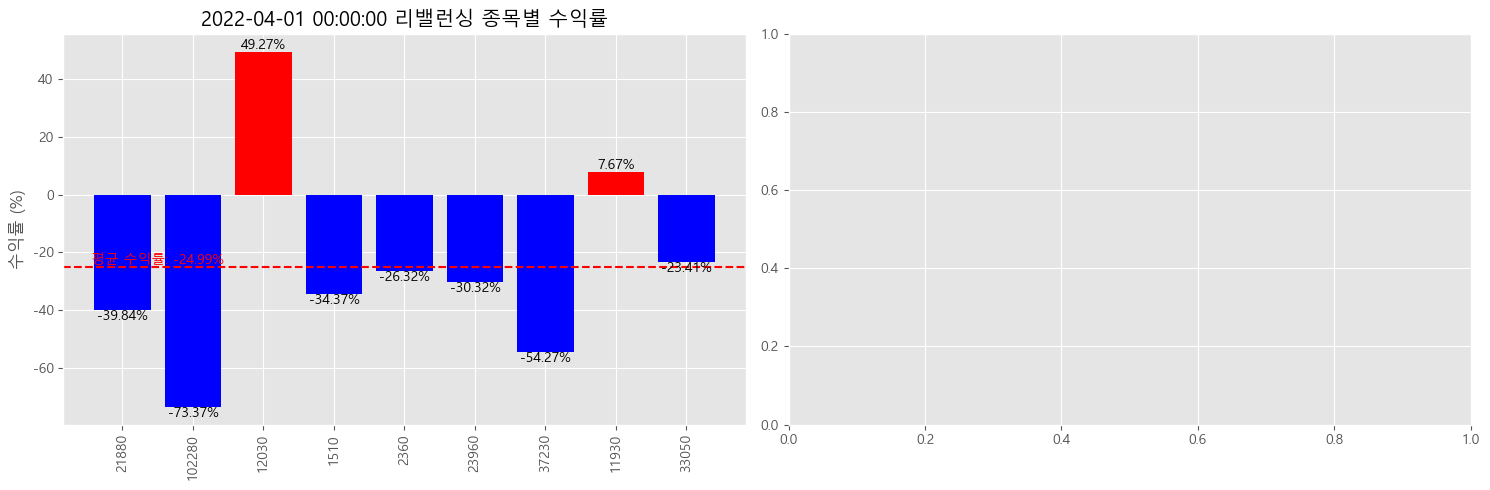

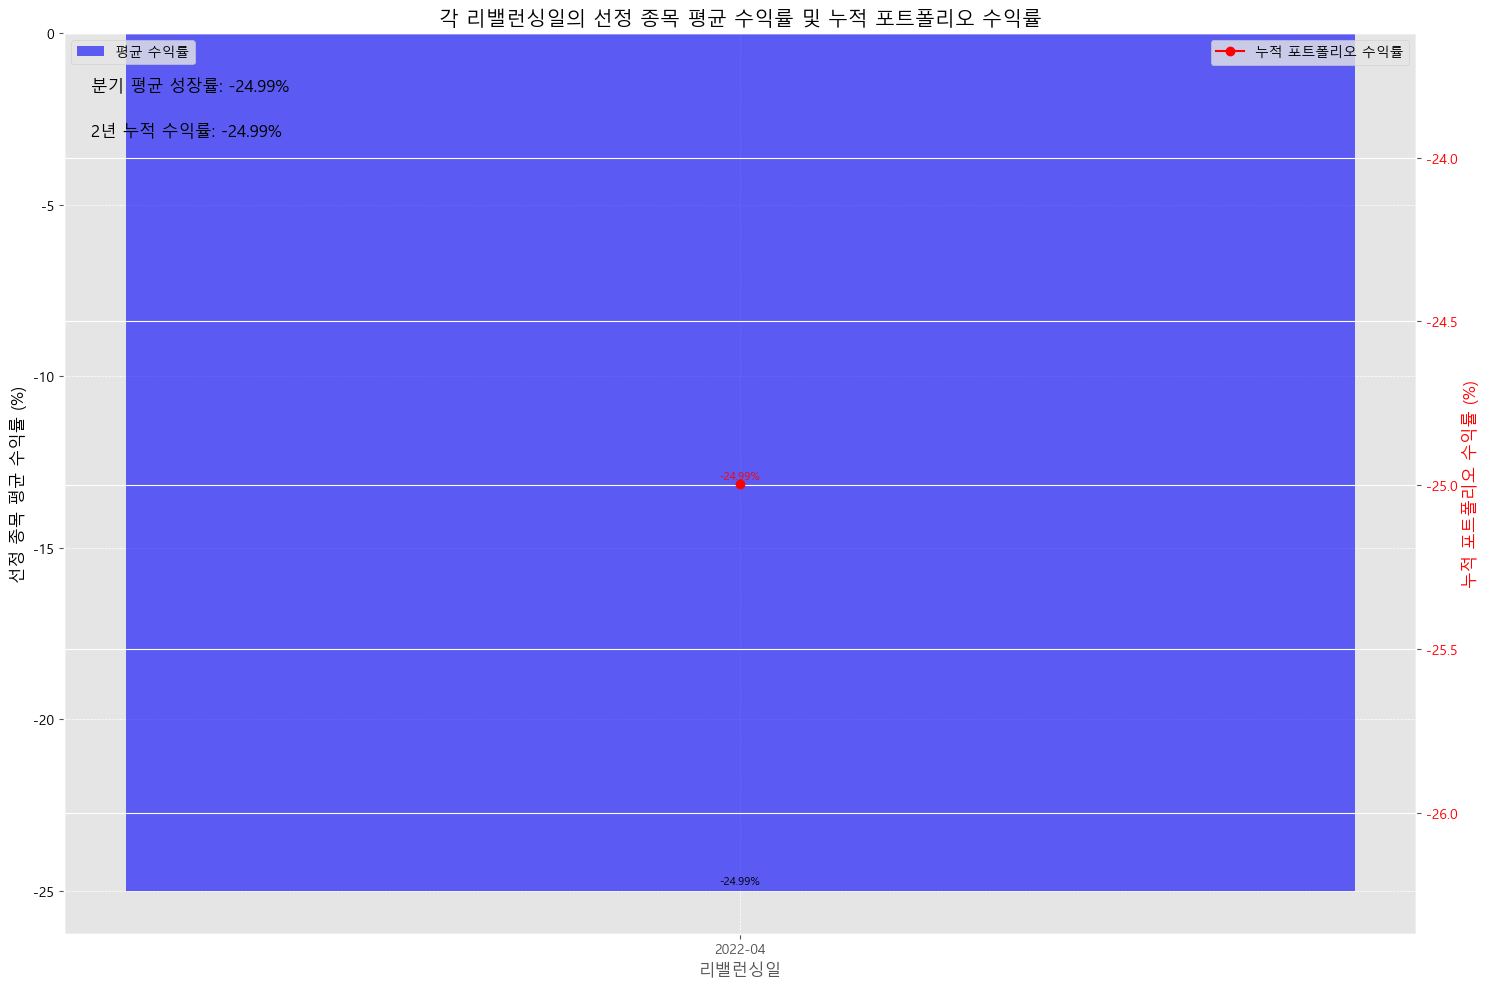

In [4]:
# 가치투자 등 새로운 전략의 종목코드 받아서 시각화 / 종목코드는 문자열, 0 포함 6자리로 입력

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
from datetime import datetime

# 수정된 select_stocks 함수: 주어진 종목코드를 사용하여 수익률 계산
def select_stocks_given_codes(close_df, rebalancing_dates, selected_stocks_dict):
    stock_returns_dict = {}
    individual_stock_returns_dict = {}
    
    for date, selected_stocks in selected_stocks_dict.items():
        # 해당 기간의 데이터 추출
        if rebalancing_dates.get_loc(date) + 1 < len(rebalancing_dates):
            next_date = rebalancing_dates[rebalancing_dates.get_loc(date) + 1]

        else:
            next_date = close_df['Date'].max()
        
        next_period_df = close_df[(close_df['Date'] >= date) & (close_df['Date'] < next_date)]
        selected_stocks = [stock.lstrip('0') for stock in selected_stocks_dict[date]]
        returns = (next_period_df[selected_stocks].iloc[-1] - next_period_df[selected_stocks].iloc[0]) / next_period_df[selected_stocks].iloc[0]
        
        # 종목별 수익률 저장
        stock_returns_dict[date] = returns.mean() * 100  # 퍼센트 단위로 변환
        individual_stock_returns_dict[date] = returns * 100  # 퍼센트 단위로 변환
    
    return stock_returns_dict, individual_stock_returns_dict


# 각 리밸런싱일에 대한 개별 주식 수익률을 시각화하는 함수
def visualize_individual_stock_returns(individual_stock_returns_dict):
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] = False
    plt.style.use('ggplot')  # 그래프 스타일 설정
    
    num_plots = len(individual_stock_returns_dict)
    num_columns = 2
    num_rows = num_plots // num_columns + (num_plots % num_columns > 0)

    fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))
    axs = axs.flatten()
    
    for ax, (date, returns) in zip(axs, individual_stock_returns_dict.items()):
        # NaN 값이 있을 경우 제외하고 평균을 계산
        valid_returns = returns.dropna()
        if len(valid_returns) == 0:  # 유효한 수익률이 없는 경우 그래프를 건너뜀
            continue

        stocks = valid_returns.index
        performance = valid_returns.values
        colors = ['red' if r > 0 else 'blue' for r in performance]
        ax.bar(stocks, performance, color=colors)
        ax.set_title(f'{date} 리밸런싱 종목별 수익률')

        ax.xaxis.set_major_locator(FixedLocator(range(len(stocks))))
        ax.set_xticklabels(stocks, rotation=90)
        ax.set_ylabel('수익률 (%)')
        
        # 유효한 수익률만을 사용하여 평균 계산
        average_return = valid_returns.mean()
        ax.axhline(average_return, color='red', linestyle='--')
        if pd.notna(average_return):
            ax.text(0.5, average_return, f'평균 수익률: {average_return:.2f}%', color='red', ha='center', va='bottom')

        # 유효한 위치 값만을 사용하여 텍스트 추가
        for i, v in enumerate(performance):
            if pd.notna(v):
                ax.text(i, v, f"{v:.2f}%", color='black', ha='center', va='bottom' if v > 0 else 'top')

    plt.tight_layout()
    plt.show()

# 포트폴리오 성과를 시각화하는 함수
def visualize_portfolio_performance(portfolio_returns):
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] = False

    # 누적 포트폴리오 수익률 계산
    cumulative_portfolio_returns = [(np.prod([1 + ret/100 for ret in list(portfolio_returns.values())[:i+1]]) - 1) * 100 for i in range(len(portfolio_returns))]

    # 분기 평균 성장률과 누적 수익률 계산
    quarterly_average_growth = np.mean(list(portfolio_returns.values()))
    total_cumulative_return = cumulative_portfolio_returns[-1]

    # 그래프 생성
    fig, ax1 = plt.subplots(figsize=(15, 10))

    # 날짜 형식 변환
    formatted_dates = [date.strftime("%Y-%m") for date in portfolio_returns.keys()]

    # 각 리밸런싱일에 선정된 종목들의 평균 수익률 막대그래프로 그리기
    colors = ['red' if value > 0 else 'blue' for value in portfolio_returns.values()]
    bars = ax1.bar(formatted_dates, portfolio_returns.values(), color=colors, label='평균 수익률', alpha=0.6)
    ax1.set_title('각 리밸런싱일의 선정 종목 평균 수익률 및 누적 포트폴리오 수익률')
    ax1.set_xlabel('리밸런싱일')
    ax1.set_ylabel('선정 종목 평균 수익률 (%)', color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax1.axhline(0, color='black', linewidth=0.6)

    # 막대 위에 수치 표시
    for bar, value in zip(bars, portfolio_returns.values()):
        height = bar.get_height()
        ax1.annotate(f'{value:.2f}%',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=8, color='black')

    # 포트폴리오의 누적 수익률 선그래프로 그리기
    ax2 = ax1.twinx()
    lines, = ax2.plot(formatted_dates, cumulative_portfolio_returns, color='red', label='누적 포트폴리오 수익률', marker='o')
    ax2.set_ylabel('누적 포트폴리오 수익률 (%)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # 선 위에 수치 표시
    for i, txt in enumerate(cumulative_portfolio_returns):
        ax2.annotate(f'{txt:.2f}%', 
                     (formatted_dates[i], cumulative_portfolio_returns[i]), 
                     textcoords="offset points", 
                     xytext=(0,3), 
                     ha='center', fontsize=8, color='red')

    # 분기 평균 성장률과 10년 누적 수익률을 그래프에 텍스트로 추가
    ax1.text(0.02, 0.95, f'분기 평균 성장률: {quarterly_average_growth:.2f}%', transform=ax1.transAxes, fontsize=12, color='black', verticalalignment='top')
    ax2.text(0.02, 0.90, f'2년 누적 수익률: {total_cumulative_return:.2f}%', transform=ax1.transAxes, fontsize=12, color='black', verticalalignment='top')

    # 범례 표시
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # 그래프 레이아웃 조정 및 표시
    plt.tight_layout()
    plt.show()



# 메인 함수: 주어진 종목 코드를 사용하여 결과 시각화
def main_given_codes(close_df_path, rebalancing_dates, selected_stocks_dict):
    # 데이터 로드
    close_df = pd.read_csv(close_df_path)
    close_df['Date'] = pd.to_datetime(close_df['Date'])  # 날짜를 datetime 객체로 변환

    # 종목 선정 및 수익률 계산
    stock_returns_dict, individual_stock_returns_dict = select_stocks_given_codes(close_df, rebalancing_dates, selected_stocks_dict)

    # 개별 종목 수익률 시각화
    visualize_individual_stock_returns(individual_stock_returns_dict)
    
    # 각 리밸런싱일에 선정된 종목들의 평균 수익률 계산
    portfolio_returns = {date: np.mean(returns) for date, returns in stock_returns_dict.items()}

    # 결과 시각화
    visualize_portfolio_performance(portfolio_returns)

# 임시로 rebalancing_dates와 selected_stocks_dict를 정의합니다. 실제 사용 시 주어진 데이터로 대체해야 합니다.
rebalancing_dates = pd.to_datetime([
    '2022-04-01'
])

selected_stocks_dict = {
    pd.Timestamp('2022-04-01'): ['021880', '078590', '102280', '012030', '001510', '002360', '023960', '037230', '011930', '033050']
    # ... 다른 날짜와 종목 코드들도 이와 같이 정의합니다.
}

# 실제 사용 시 아래 코드를 주석 해제하고 'reshape_df_1.0.csv'를 실제 데이터셋의 경로로 변경해야 합니다.
main_given_codes('reshape_df_1.0.csv', rebalancing_dates, selected_stocks_dict)


The following stock codes were not found in the DataFrame: ['104110', '900090', '900090', '900270']
Missing stock codes: ['104110', '900090', '900090', '900270']


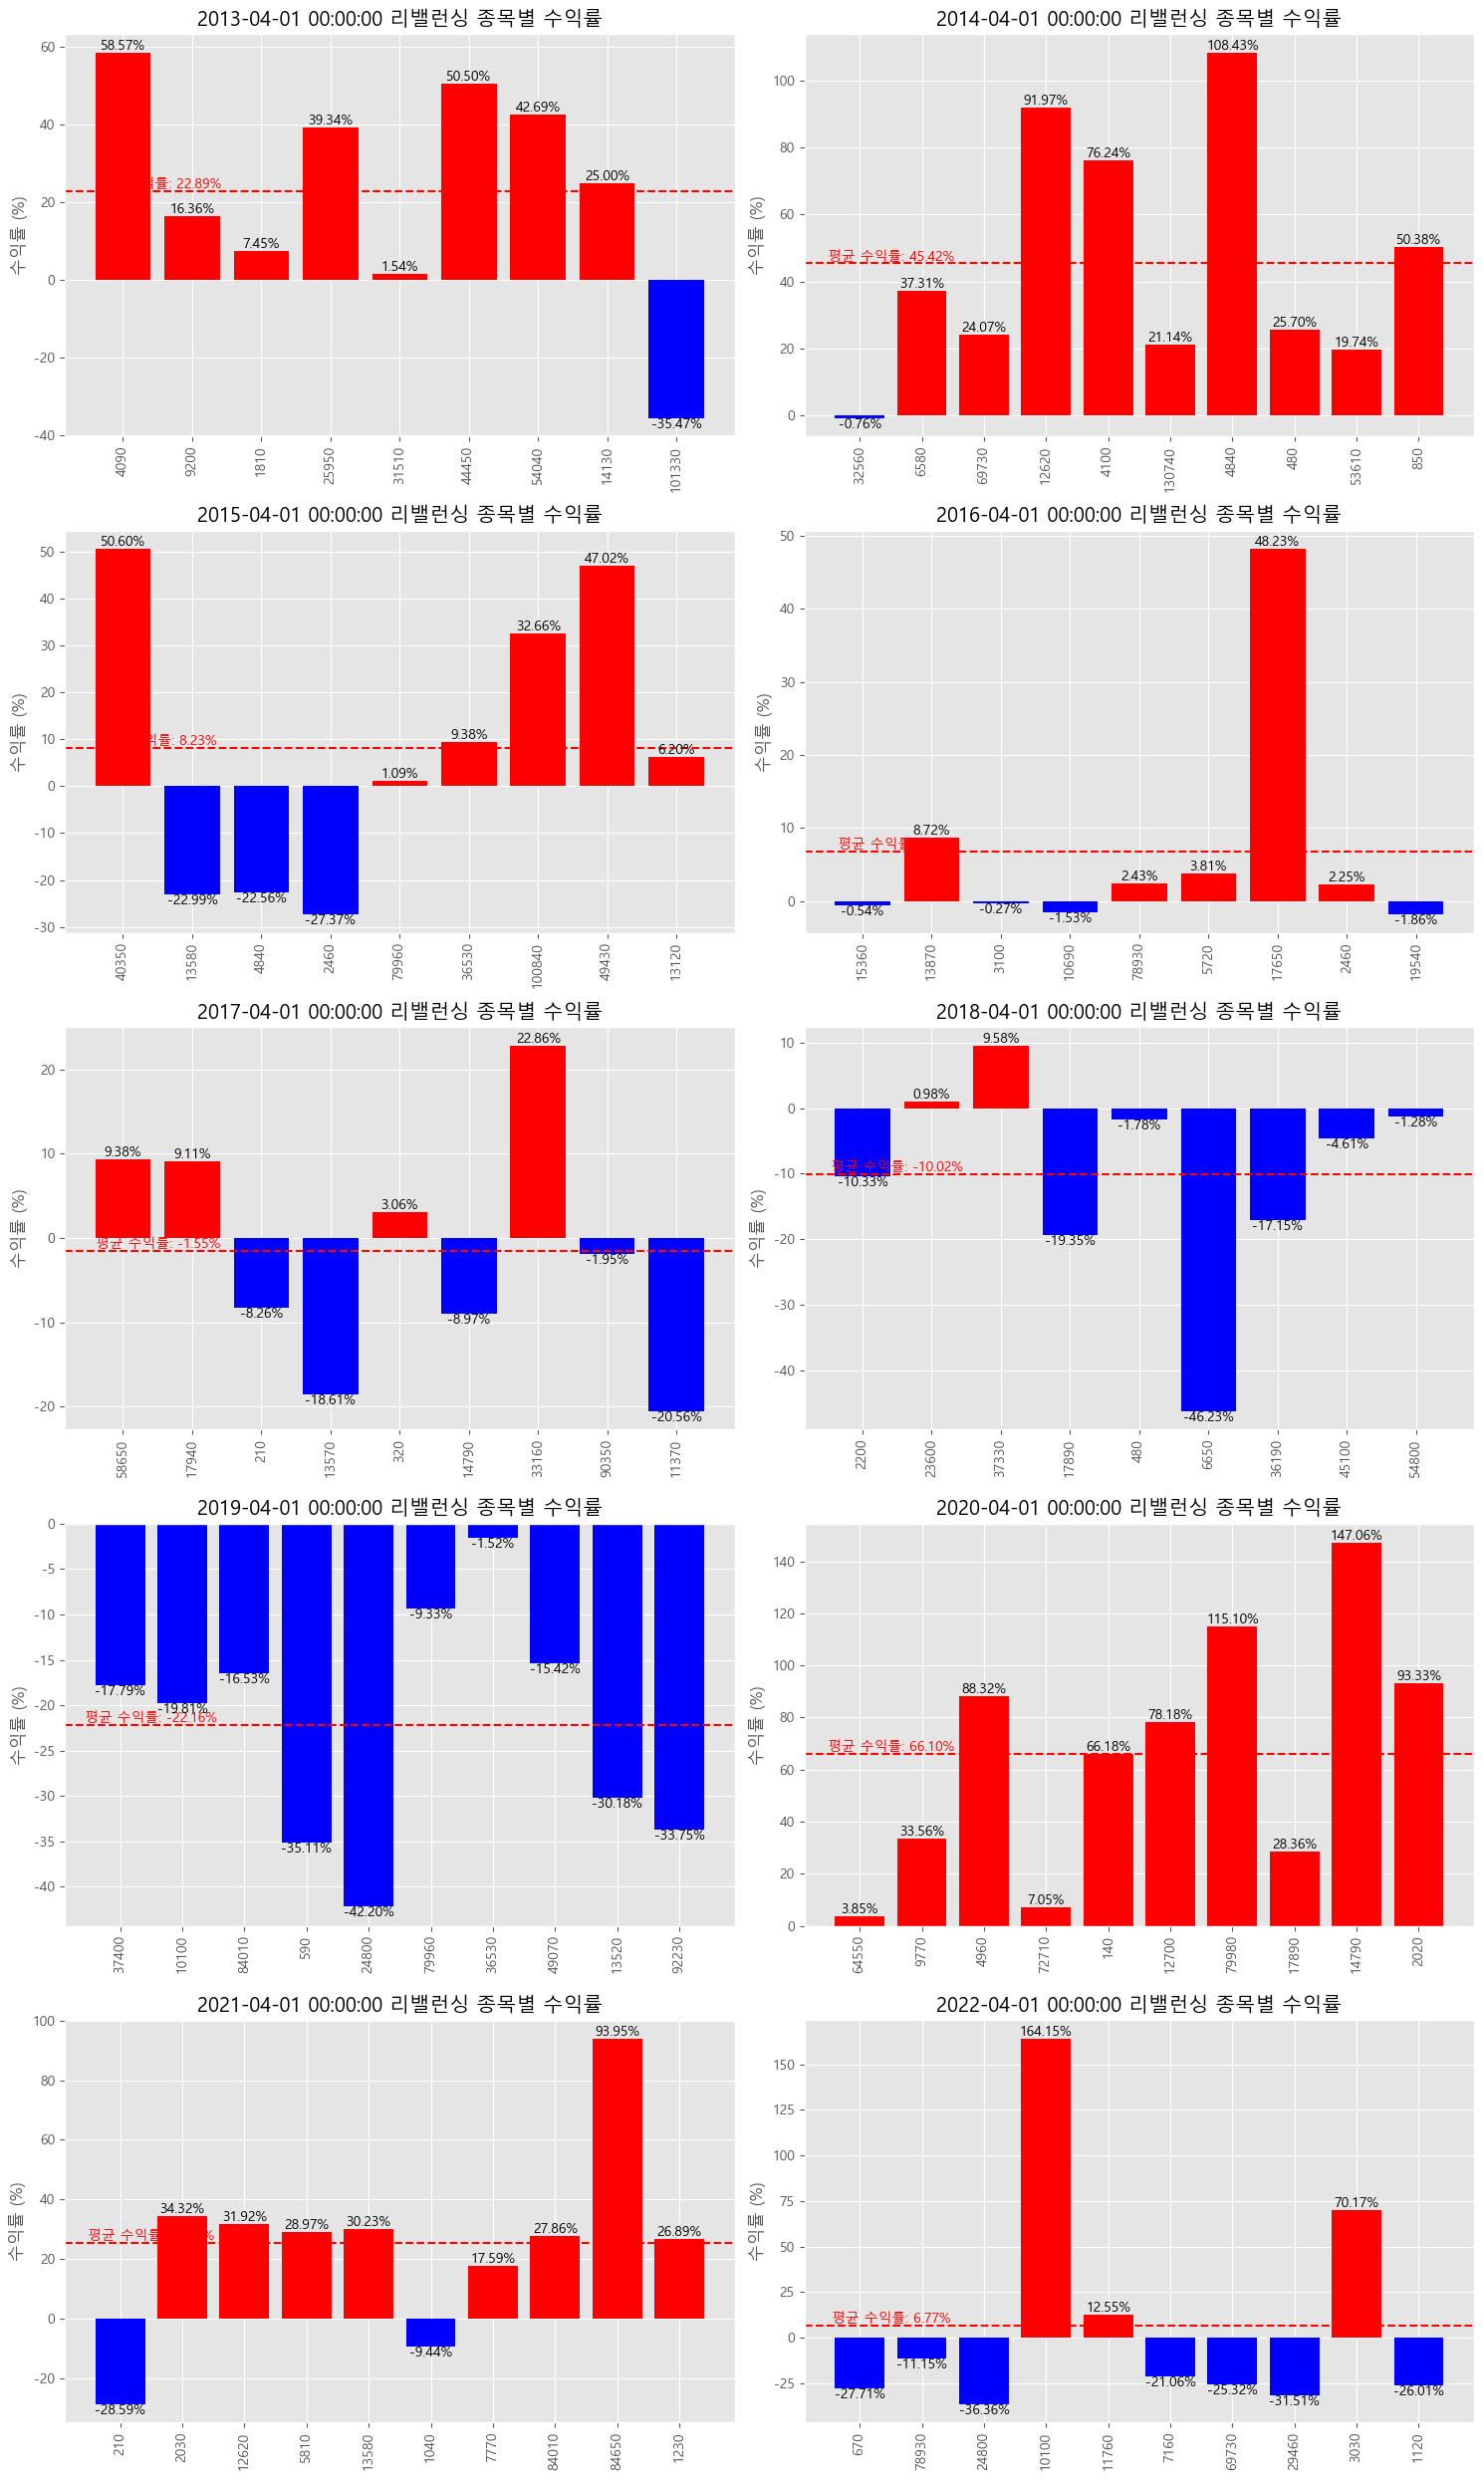

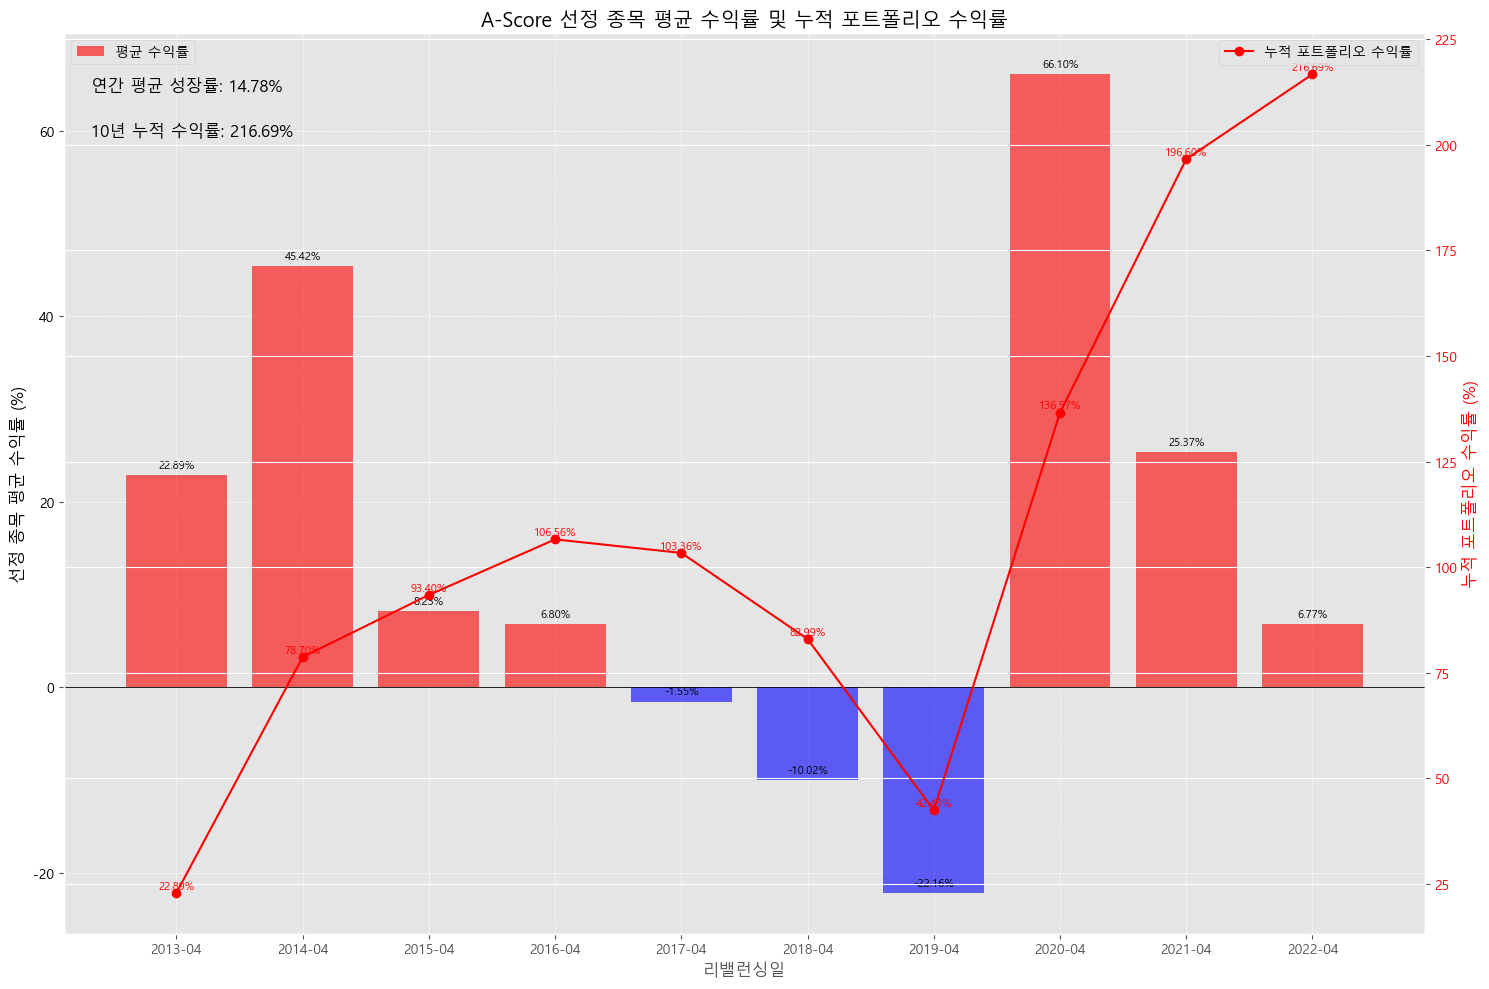

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator

# rebalancing_dates와 selected_stocks_dict의 날짜를 문자열로 사용, 기존 코드와 동일. 위의 코드는 Timestamp 형태로 사용.

# 수정된 select_stocks 함수: 주어진 종목코드를 사용하여 수익률 계산
# 리스트에서 날짜의 위치를 찾는 코드
def select_stocks_given_codes(close_df, rebalancing_dates, selected_stocks_dict):
    stock_returns_dict = {}
    individual_stock_returns_dict = {}
    missing_stocks = []  # 존재하지 않는 종목 코드를 저장할 리스트

    for date_str, selected_stocks in selected_stocks_dict.items():
        date = pd.to_datetime(date_str)
        date_index = rebalancing_dates.index(date_str)
        if date_index + 1 < len(rebalancing_dates):
            next_date = pd.to_datetime(rebalancing_dates[date_index + 1])
        else:
            next_date = close_df['Date'].max()

        next_period_df = close_df[(close_df['Date'] >= date) & (close_df['Date'] < next_date)]
        
        # 종목 코드에서 선행하는 '0' 제거
        formatted_selected_stocks = [stock.lstrip('0') for stock in selected_stocks]

        # 존재하는 종목 코드만 필터링
        existing_stocks = [stock for stock in formatted_selected_stocks if stock in next_period_df.columns]
        missing_stocks += [stock for stock in formatted_selected_stocks if stock not in next_period_df.columns]
        
        # 수익률 계산을 위해 존재하는 종목만 선택
        if existing_stocks:  # 존재하는 종목이 있을 때만 계산 수행
            returns = (next_period_df[existing_stocks].iloc[-1] - next_period_df[existing_stocks].iloc[0]) / next_period_df[existing_stocks].iloc[0]
            # 종목별 수익률 저장
            stock_returns_dict[date] = returns.mean() * 100  # 퍼센트 단위로 변환
            individual_stock_returns_dict[date] = returns * 100  # 퍼센트 단위로 변환

    # 존재하지 않는 종목 코드 출력
    if missing_stocks:
        print(f"The following stock codes were not found in the DataFrame: {missing_stocks}")

    return stock_returns_dict, individual_stock_returns_dict, missing_stocks


# 나머지 코드는 동일하게 유지하고, main_given_codes 함수 호출 부분에서도 변경이 필요합니다.



# 각 리밸런싱일에 대한 개별 주식 수익률을 시각화하는 함수
def visualize_individual_stock_returns(individual_stock_returns_dict):
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] = False
    plt.style.use('ggplot')  # 그래프 스타일 설정
    
    num_plots = len(individual_stock_returns_dict)
    num_columns = 2
    num_rows = num_plots // num_columns + (num_plots % num_columns > 0)

    fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))
    axs = axs.flatten()
    
    for ax, (date, returns) in zip(axs, individual_stock_returns_dict.items()):
        # NaN 값이 있을 경우 제외하고 평균을 계산
        valid_returns = returns.dropna()
        if len(valid_returns) == 0:  # 유효한 수익률이 없는 경우 그래프를 건너뜀
            continue

        stocks = valid_returns.index
        performance = valid_returns.values
        colors = ['red' if r > 0 else 'blue' for r in performance]
        ax.bar(stocks, performance, color=colors)
        ax.set_title(f'{date} 리밸런싱 종목별 수익률')

        ax.xaxis.set_major_locator(FixedLocator(range(len(stocks))))
        ax.set_xticklabels(stocks, rotation=90)
        ax.set_ylabel('수익률 (%)')
        
        # 유효한 수익률만을 사용하여 평균 계산
        average_return = valid_returns.mean()
        ax.axhline(average_return, color='red', linestyle='--')
        if pd.notna(average_return):
            ax.text(0.5, average_return, f'평균 수익률: {average_return:.2f}%', color='red', ha='center', va='bottom')

        # 유효한 위치 값만을 사용하여 텍스트 추가
        for i, v in enumerate(performance):
            if pd.notna(v):
                ax.text(i, v, f"{v:.2f}%", color='black', ha='center', va='bottom' if v > 0 else 'top')

    plt.tight_layout()
    plt.show()

# 포트폴리오 성과를 시각화하는 함수
def visualize_portfolio_performance(portfolio_returns):
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] = False

    # 누적 포트폴리오 수익률 계산
    cumulative_portfolio_returns = [(np.prod([1 + ret/100 for ret in list(portfolio_returns.values())[:i+1]]) - 1) * 100 for i in range(len(portfolio_returns))]

    # 분기 평균 성장률과 누적 수익률 계산
    quarterly_average_growth = np.mean(list(portfolio_returns.values()))
    total_cumulative_return = cumulative_portfolio_returns[-1]

    # 그래프 생성
    fig, ax1 = plt.subplots(figsize=(15, 10))

    # 날짜 형식 변환
    formatted_dates = [date.strftime("%Y-%m") for date in portfolio_returns.keys()]

    # 각 리밸런싱일에 선정된 종목들의 평균 수익률 막대그래프로 그리기
    colors = ['red' if value > 0 else 'blue' for value in portfolio_returns.values()]
    bars = ax1.bar(formatted_dates, portfolio_returns.values(), color=colors, label='평균 수익률', alpha=0.6)
    ax1.set_title('A-Score 선정 종목 평균 수익률 및 누적 포트폴리오 수익률')
    ax1.set_xlabel('리밸런싱일')
    ax1.set_ylabel('선정 종목 평균 수익률 (%)', color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax1.axhline(0, color='black', linewidth=0.6)

    # 막대 위에 수치 표시
    for bar, value in zip(bars, portfolio_returns.values()):
        height = bar.get_height()
        ax1.annotate(f'{value:.2f}%',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=8, color='black')

    # 포트폴리오의 누적 수익률 선그래프로 그리기
    ax2 = ax1.twinx()
    lines, = ax2.plot(formatted_dates, cumulative_portfolio_returns, color='red', label='누적 포트폴리오 수익률', marker='o')
    ax2.set_ylabel('누적 포트폴리오 수익률 (%)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # 선 위에 수치 표시
    for i, txt in enumerate(cumulative_portfolio_returns):
        ax2.annotate(f'{txt:.2f}%', 
                     (formatted_dates[i], cumulative_portfolio_returns[i]), 
                     textcoords="offset points", 
                     xytext=(0,3), 
                     ha='center', fontsize=8, color='red')

    # 분기 평균 성장률과 10년 누적 수익률을 그래프에 텍스트로 추가
    ax1.text(0.02, 0.95, f'연간 평균 성장률: {quarterly_average_growth:.2f}%', transform=ax1.transAxes, fontsize=12, color='black', verticalalignment='top')
    ax2.text(0.02, 0.90, f'10년 누적 수익률: {total_cumulative_return:.2f}%', transform=ax1.transAxes, fontsize=12, color='black', verticalalignment='top')

    # 범례 표시
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # 그래프 레이아웃 조정 및 표시
    plt.tight_layout()
    plt.show()



# 메인 함수: 주어진 종목 코드를 사용하여 결과 시각화
# 메인 함수: 주어진 종목 코드를 사용하여 결과 시각화
def main_given_codes(close_df_path, rebalancing_dates, selected_stocks_dict):
    # 데이터 로드
    close_df = pd.read_csv(close_df_path)
    close_df['Date'] = pd.to_datetime(close_df['Date'])  # 날짜를 datetime 객체로 변환

    # 종목 선정 및 수익률 계산
    stock_returns_dict, individual_stock_returns_dict, missing_stocks = select_stocks_given_codes(close_df, rebalancing_dates, selected_stocks_dict)
    
    # 존재하지 않는 종목 코드가 있을 경우 출력
    if missing_stocks:
        print(f"Missing stock codes: {missing_stocks}")

    # 개별 종목 수익률 시각화
    visualize_individual_stock_returns(individual_stock_returns_dict)
    
    # 각 리밸런싱일에 선정된 종목들의 평균 수익률 계산
    portfolio_returns = {date: np.mean(returns) for date, returns in stock_returns_dict.items()}

    # 결과 시각화
    visualize_portfolio_performance(portfolio_returns)

# 문자열 날짜 리스트를 직접 사용
rebalancing_dates = [
    '2013-04-01', '2014-04-01', '2015-04-01', '2016-04-01', '2017-04-01', '2018-04-01', '2019-04-01', '2020-04-01', '2021-04-01', '2022-04-01'
    # ... 다른 날짜도 이와 같이 추가
]

# selected_stocks_dict의 키도 문자열로 처리
selected_stocks_dict = {'2013-04-01': ['004090',
  '009200',
  '001810',
  '025950',
  '031510',
  '044450',
  '054040',
  '014130',
  '101330',
  '104110'],
 '2014-04-01': ['032560',
  '006580',
  '069730',
  '012620',
  '004100',
  '130740',
  '004840',
  '000480',
  '053610',
  '000850'],
 '2015-04-01': ['040350',
  '013580',
  '900090',
  '004840',
  '002460',
  '079960',
  '036530',
  '100840',
  '049430',
  '013120'],
 '2016-04-01': ['900090',
  '015360',
  '013870',
  '003100',
  '010690',
  '078930',
  '005720',
  '017650',
  '002460',
  '019540'],
 '2017-04-01': ['058650',
  '017940',
  '000210',
  '013570',
  '000320',
  '014790',
  '900270',
  '033160',
  '090350',
  '011370'],
 '2018-04-01': ['002200',
  '023600',
  '037330',
  '007680',
  '017890',
  '000480',
  '006650',
  '036190',
  '045100',
  '054800'],
 '2019-04-01': ['037400',
  '010100',
  '084010',
  '000590',
  '024800',
  '079960',
  '036530',
  '049070',
  '013520',
  '092230'],
 '2020-04-01': ['064550',
  '009770',
  '004960',
  '072710',
  '000140',
  '012700',
  '079980',
  '017890',
  '014790',
  '002020'],
 '2021-04-01': ['000210',
  '002030',
  '012620',
  '005810',
  '013580',
  '001040',
  '007770',
  '084010',
  '084650',
  '001230'],
 '2022-04-01': ['000670',
  '078930',
  '024800',
  '010100',
  '011760',
  '007160',
  '069730',
  '029460',
  '003030',
  '001120']
  }


# 실제 사용 시 아래 코드를 주석 해제하고 'reshape_df_1.0.csv'를 실제 데이터셋의 경로로 변경해야 합니다.
main_given_codes('reshape_df_1.0.csv', rebalancing_dates, selected_stocks_dict)


In [6]:
# 전략과 코스피/코스닥 비교(수익률 차이)

# 코스피와 코스닥의 데이터 로드하기
kospi_df = pd.read_csv('KOSPI.csv')
kosdaq_df = pd.read_csv('KOSDAQ.csv')

# 날짜 형식 변환
kospi_df['Date'] = pd.to_datetime(kospi_df['Date'])
kosdaq_df['Date'] = pd.to_datetime(kosdaq_df['Date'])

# 종가의 쉼표 제거 및 형변환
kospi_df['Price'] = kospi_df['Price'].str.replace(',', '').astype(float)
kosdaq_df['Price'] = kosdaq_df['Price'].str.replace(',', '').astype(float)

# 함수 정의: 주어진 시작일과 종료일 사이의 수익률 계산
def calculate_return(df, start_date, end_date):
    start_price = df.loc[df['Date'] == start_date, 'Price'].values[0]
    end_price = df.loc[df['Date'] == end_date, 'Price'].values[0]
    return (end_price - start_price) / start_price

# 각 리밸런싱일에 대한 전략 A, 코스피, 코스닥 수익률 계산
strategy_a_returns = []
kospi_returns = []
kosdaq_returns = []
# 리밸런싱 날짜를 datetime 객체로 변환
rebalancing_dates = pd.to_datetime([
                                    '2022-04-01', '2022-07-01', '2022-10-04',
                                    '2023-01-02', '2023-04-03', '2023-07-03', '2023-10-04'])
for i in range(len(rebalancing_dates) - 1):
    start_date = pd.to_datetime(rebalancing_dates[i])
    end_date = pd.to_datetime(rebalancing_dates[i + 1])
    
    # 전략 A의 수익률
    # 종목 코드를 문자열에서 숫자로 변환하여 키에 접근합니다.
    strategy_a_stocks = [str(stock).lstrip('0') for stock in formatted_held_stocks_dict[start_date]]
    
    # period_df는 종목 코드를 숫자로 포함해야 합니다.
    period_df = close_df[(close_df['Date'] >= start_date) & (close_df['Date'] < end_date)][strategy_a_stocks]
    
    # period_df의 각 컬럼에 대해 수익률을 계산하고 평균을 구합니다.
    strategy_a_return = ((period_df.iloc[-1] - period_df.iloc[0]) / period_df.iloc[0]).mean()
    strategy_a_returns.append(strategy_a_return)
    
    # 코스피와 코스닥 수익률 계산
    kospi_return = calculate_return(kospi_df, start_date, end_date)
    kospi_returns.append(kospi_return)
    
    kosdaq_return = calculate_return(kosdaq_df, start_date, end_date)
    kosdaq_returns.append(kosdaq_return)

def plot_benchmark_comparison(strategy_returns, kospi_returns, kosdaq_returns, rebalancing_dates):
    # 시각화 설정
    bar_width = 0.3
    index = np.arange(len(strategy_returns))
    
    # 날짜 형식을 문자열로 변환
    date_labels = [date.strftime('%Y-%m-%d') for date in rebalancing_dates[:-1]]
    
    # 그래프 그리기
    fig, ax = plt.subplots(figsize=(15, 10))
    
    bars1 = ax.bar(index, strategy_returns, bar_width, label='전략 A', alpha=0.7)
    bars2 = ax.bar(index + bar_width, kospi_returns, bar_width, label='KOSPI', alpha=0.7)
    bars3 = ax.bar(index + 2 * bar_width, kosdaq_returns, bar_width, label='KOSDAQ', alpha=0.7)
    
    # 각 막대 위에 수치 표시
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2%}',  # 백분율 형식으로 변경
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3 if height > 0 else -15),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=10, color='black')
    
    # 그래프 설정
    ax.set_title('전략 A vs KOSPI vs KOSDAQ 수익률 비교', fontsize=16)
    ax.set_ylabel('수익률 (%)', fontsize=14)
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(date_labels, rotation=45, fontsize=12)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend()

    # 그래프 레이아웃 조정 및 표시
    plt.tight_layout()
    plt.show()

# 그래프 생성
plot_benchmark_comparison(strategy_a_returns, kospi_returns, kosdaq_returns, rebalancing_dates)

KeyError: 'Date'

In [ ]:
import riskfolio as rp

# 포트폴리오 객체 생성
port = rp.Portfolio(returns=rets)

# 입력값 계산
method_mu = 'hist'  # 역사적 데이터를 바탕으로 기대 수익률 추정
method_cov = 'hist'  # 역사적 데이터를 바탕으로 분산-공분산 행렬 추정

# 객체에 수익률 및 분산-공분산 입력
port.assets_stats(method_mu=method_mu, method_cov=method_cov)

model = 'Classic'  # 모델 입력. Classic(역사적 데이터), BL(블랙-리터만), FM(팩터 모형)
rm = 'MV'  # 위험 측정 방법. MV는 표준편차를 의미
obj = 'Sharpe'  # 목적함수. MinRisk(최소분산), MaxRet(최대수익률), Utility(효용) or Sharpe(샤프지수)
hist = True  # 역사적 데이터 사용
rf = 0  # 무위험 수익률
l = 0  # 위험 회피 계수, obj가 'Utility' 일 때만 사용

# 최적화
w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

round(w.T, 4)